In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import swiss_roll_dataset_generator as roll
import dataset_generator


In [58]:
figure_num = 100
figure_point_cnt = 1600
deterministic_param_scatter = False
p = 2
sorted = True
noise_level=0
deterministic_scatter = True
lw = [1, 1]
up = [10, 10]
control_vars = dataset_generator.get_control_vars(deterministic=deterministic_param_scatter, dimensionality=p,
                                                  size=figure_num,
                                                  lw=lw, up=up)
# control_vars = np.array([[1, 1], [1, 1],[1, 1], [1, 1], [1, 1],[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]])
rolls = roll.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
k = 4
c = 400
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, rolls, k)

q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

ld_embedding = mcu.reduce_dimensions(q, 2)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1),
                     reconstructed_y_to_params)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [52]:
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

In [53]:
ld_embedding = mcu.reduce_dimensions(q, 2)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1),
                     reconstructed_y_to_params)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [5]:
pieces_cnt = 12
test_data_size = 50
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i], intervals[1][j]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=p,
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [1.40210886 0.95724063], x_err = 370.332550508437
x_real = [0.654792   0.11310147]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 387.51687042880053
x_real = [0.01535764 0.46559136]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 283.358578861171
x_real = [0.71007363 0.40296691]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 142.62004991965108
x_real = [0.98348125 0.45429857]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 425.89140207874664
x_real = [0.38253471 0.39975121]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 317.8888095641115
x_real = [0.66881112 0.00918132]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 238.18232747442497
x_real = [0.98274899 0.16293422]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 404.2020165996269
x_real = [0.09615976 0.47262871]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 428.5181024452803
x_real = [0.42547451 0.11195404]
-----------
x_opt  = [1.40210886 0.95724063], x_err =

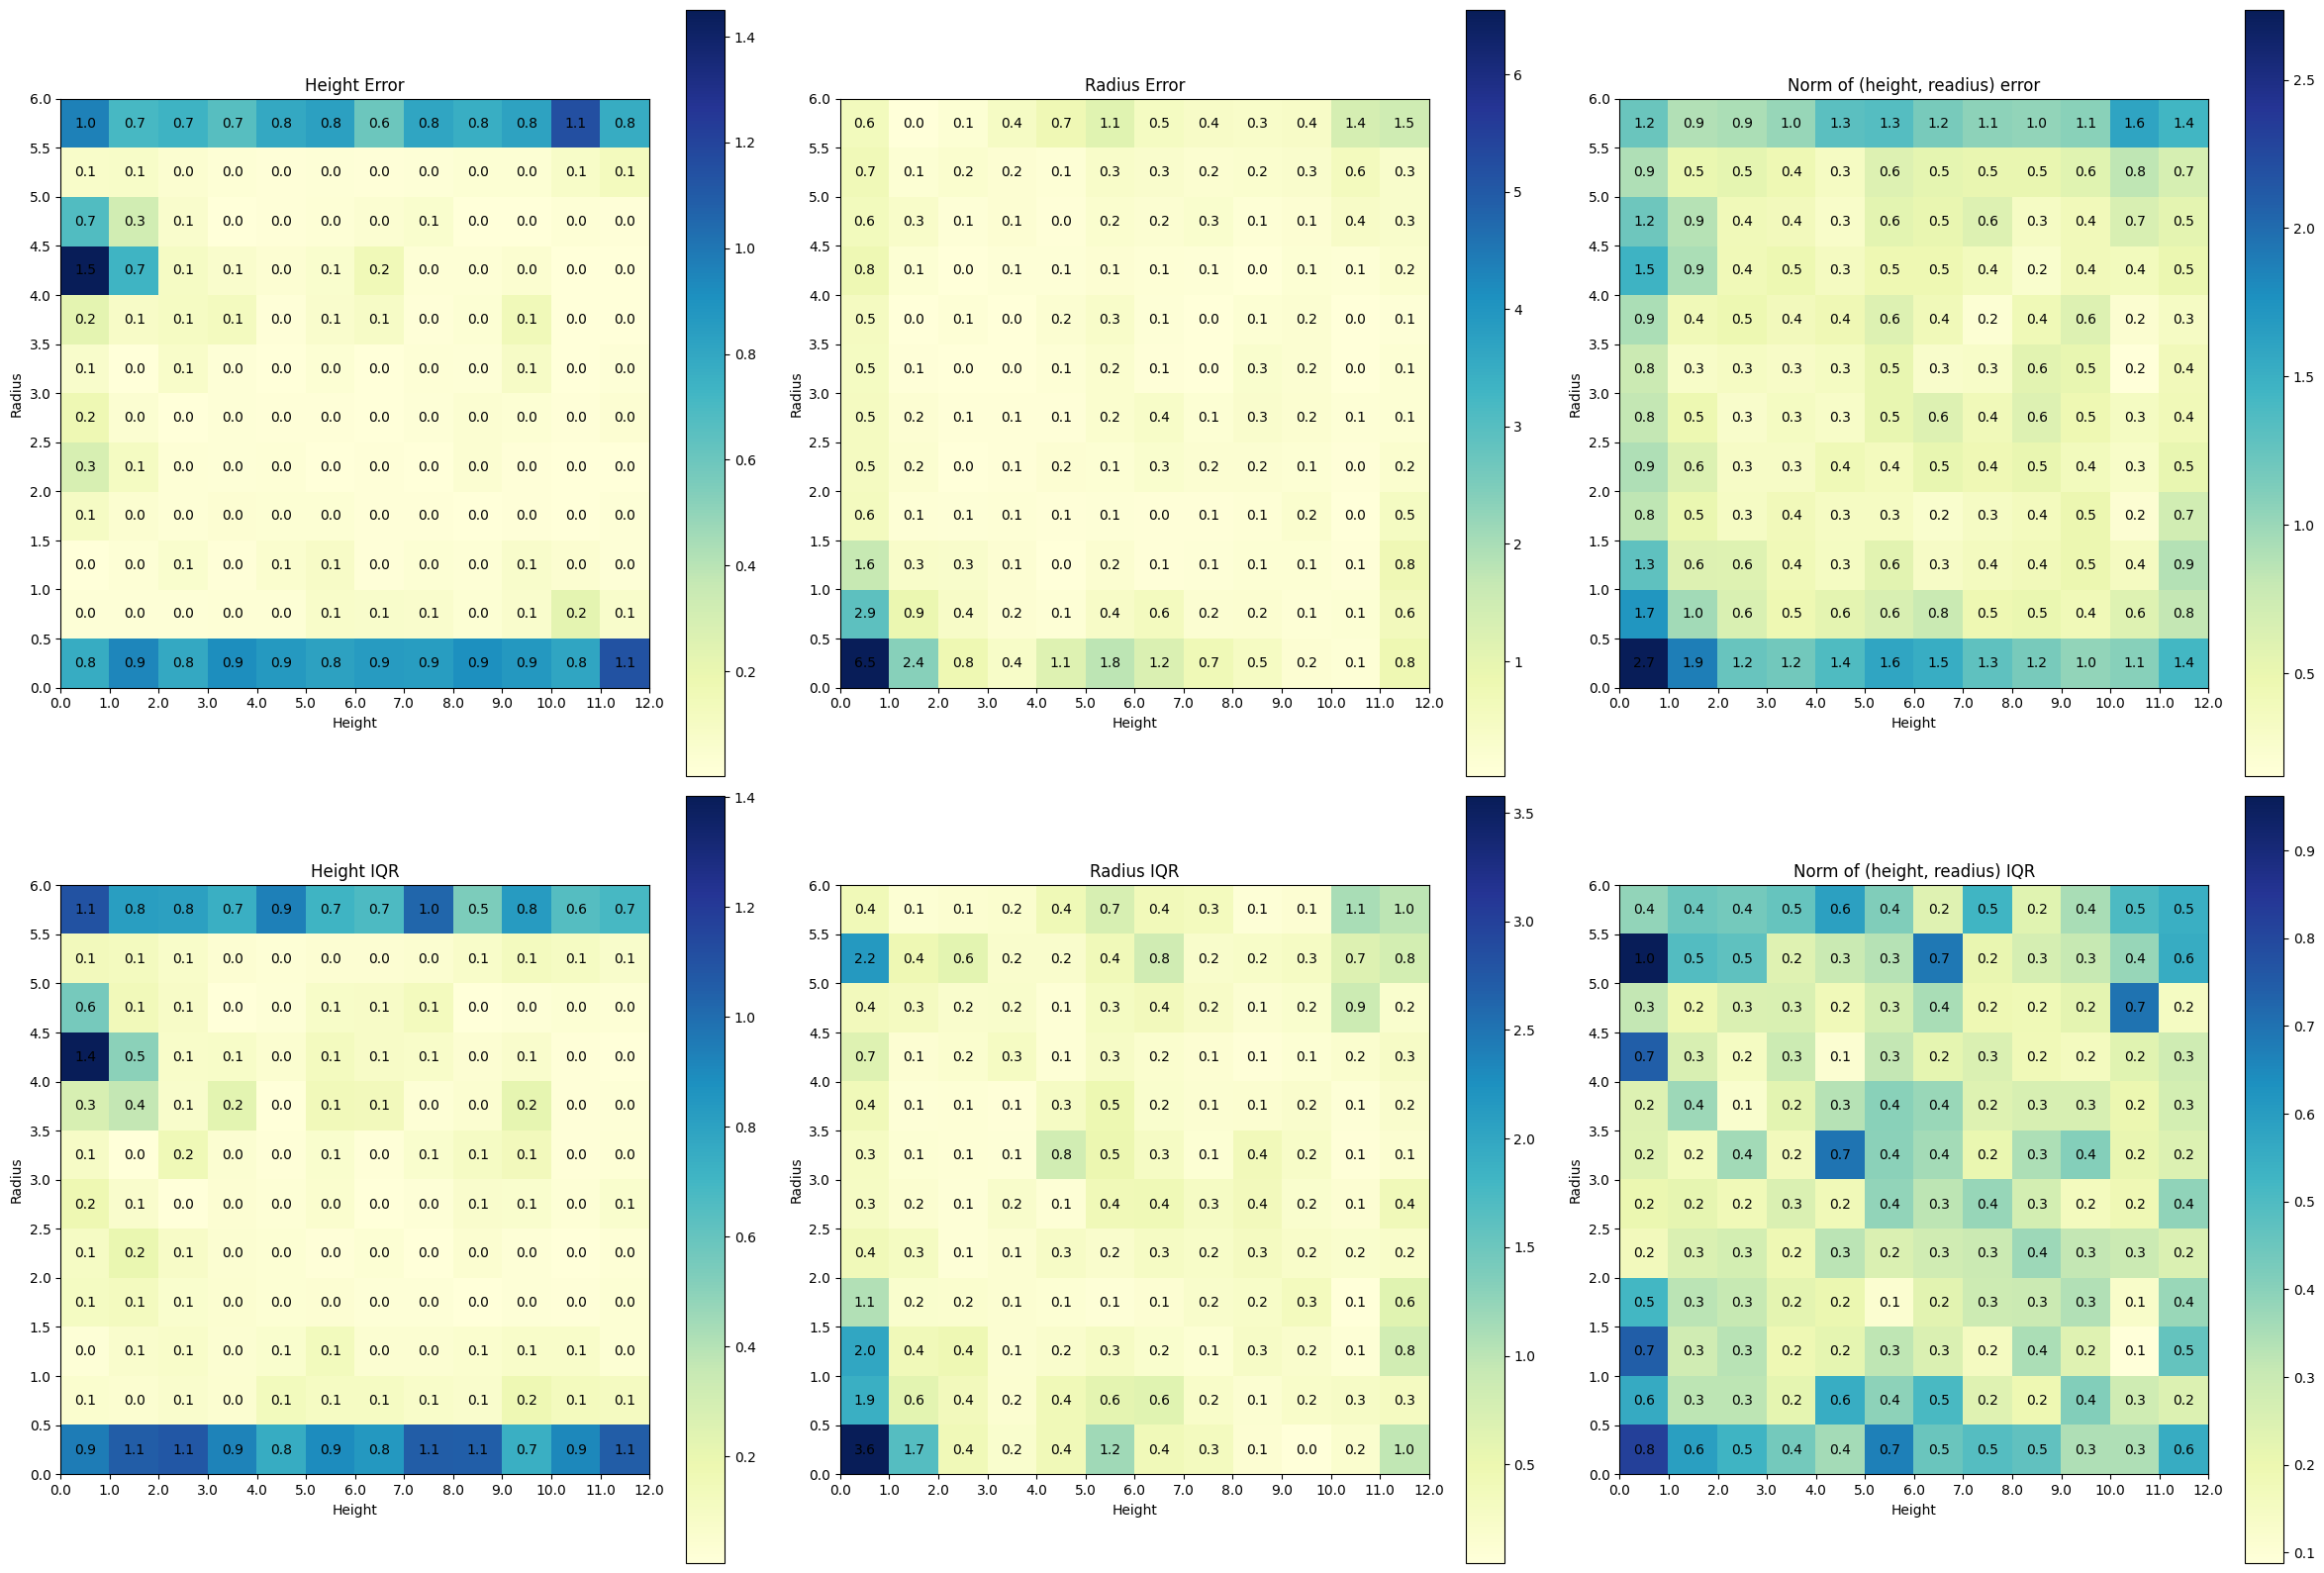

In [6]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()

In [7]:
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i + 1], intervals[1][j + 1]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=p,
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]
-----------
x_opt  = [1.40210886 0.95724063], x_err = 58.93409350374702
x_real = [1.  0.5]

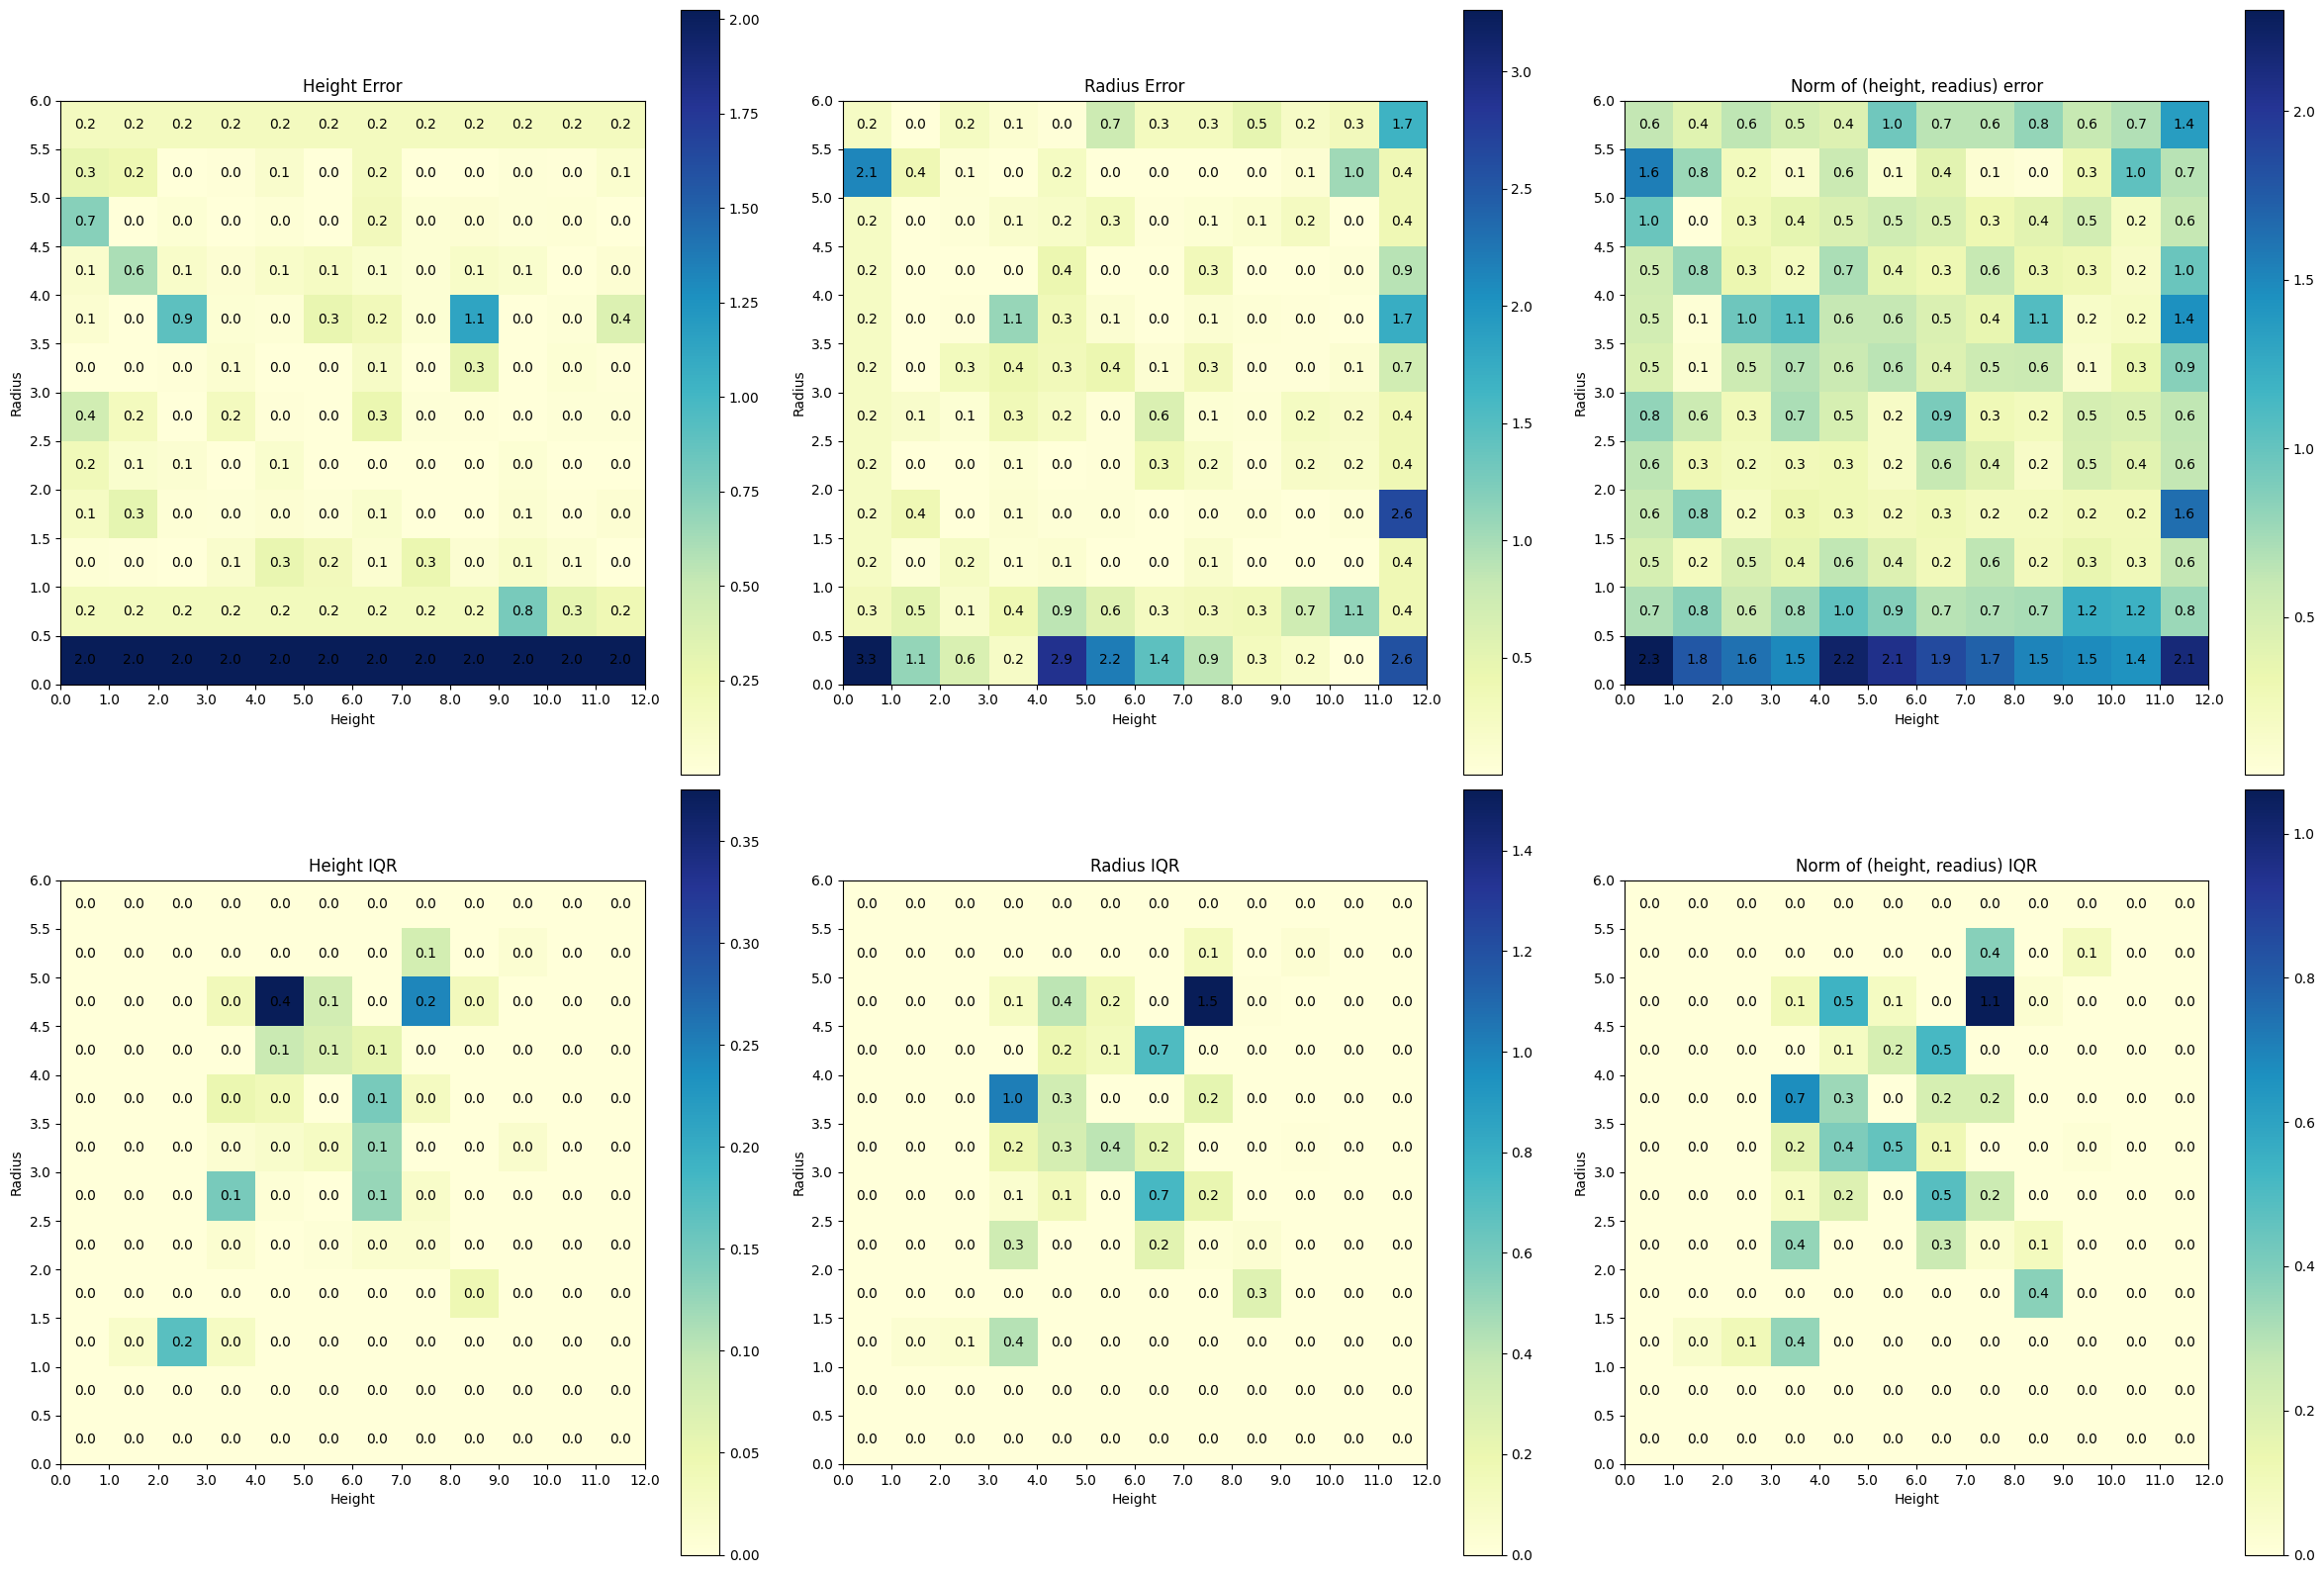

In [8]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()